In [ ]:
import os
import numpy as np
import pandas as pd
from glob import glob
import random
import cv2
import matplotlib.pyplot as plt

In [ ]:
from IPython.display import clear_output

%pip install -q tensorflow==2.4.1

clear_output()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [ ]:
# gpus = tf.config.list_physical_devices(device_type='GPU')
# tf.config.set_visible_devices(gpus, device_type='GPU')

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.data import Dataset
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
# Setting seeds for reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# New Section

In [ ]:
# IMAGE_DIR = 'original_images'
# MASK_DIR = 'label_images_semantic'
IMAGE_DIR = '/content/drive/MyDrive/original_images'
MASK_DIR = '/content/drive/MyDrive/label_images_semantic'
BATCH_SIZE=4
EPOCHS=10
LR = 1e-4
HEIGHT = 512
WIDTH = 512

In [ ]:
print(IMAGE_DIR)

/content/drive/MyDrive/original_images


In [ ]:
# sample_mask = cv2.imread('label_images_semantic/002.png',cv2.IMREAD_GRAYSCALE)
sample_mask = cv2.imread(f'{MASK_DIR}/002.png',cv2.IMREAD_GRAYSCALE)
num_classes = np.max(sample_mask) + 1
height = sample_mask.shape[0]
width = sample_mask.shape[1]
print('the number of total classes: ', num_classes)
print('sample image height {}, width {}'.format(height, width))

the number of total classes:  23
sample image height 4000, width 6000


In [ ]:
image_paths = glob(os.path.join(IMAGE_DIR, '*.jpg'))
image_paths.sort()
mask_paths = glob(os.path.join(MASK_DIR, '*.png'))
mask_paths.sort()
print('total number of images: ', len(image_paths))

total number of images:  400


In [ ]:
print(image_paths)
print(mask_paths)

['/content/drive/MyDrive/original_images/000.jpg', '/content/drive/MyDrive/original_images/001.jpg', '/content/drive/MyDrive/original_images/002.jpg', '/content/drive/MyDrive/original_images/003.jpg', '/content/drive/MyDrive/original_images/004.jpg', '/content/drive/MyDrive/original_images/005.jpg', '/content/drive/MyDrive/original_images/006.jpg', '/content/drive/MyDrive/original_images/008.jpg', '/content/drive/MyDrive/original_images/011.jpg', '/content/drive/MyDrive/original_images/013.jpg', '/content/drive/MyDrive/original_images/014.jpg', '/content/drive/MyDrive/original_images/015.jpg', '/content/drive/MyDrive/original_images/016.jpg', '/content/drive/MyDrive/original_images/018.jpg', '/content/drive/MyDrive/original_images/019.jpg', '/content/drive/MyDrive/original_images/021.jpg', '/content/drive/MyDrive/original_images/022.jpg', '/content/drive/MyDrive/original_images/023.jpg', '/content/drive/MyDrive/original_images/026.jpg', '/content/drive/MyDrive/original_images/028.jpg',

In [ ]:
data = pd.DataFrame(np.array([image_paths, mask_paths]).T, columns=['image','mask'])
print(data.iloc[0,0])
print(data.iloc[0,1])

/content/drive/MyDrive/original_images/000.jpg
/content/drive/MyDrive/label_images_semantic/000.png


In [ ]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(image_paths, mask_paths, test_size=0.1, random_state=19)
print('total number of images in training set: ', len(train_x))
print('total number of images in testing set: ', len(test_x))

total number of images in training set:  360
total number of images in testing set:  40


In [ ]:
def read_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = image / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [HEIGHT, WIDTH])
    mask = tf.cast(tf.squeeze(mask), dtype=tf.int32)
    mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
    return image, mask

def augment_image_batch1(image, mask):
    new_seed = np.random.randint(100)
    print(image.shape)
    print(mask.shape)
    image = tf.image.resize(image, [int(1.2 * HEIGHT), int(1.2 * WIDTH)])
    mask = tf.image.resize(mask, [int(1.2 * HEIGHT), int(1.2 * WIDTH)])
    image = tf.image.random_crop(image, (HEIGHT, WIDTH, 3), seed=new_seed)
    mask = tf.image.random_crop(mask, (HEIGHT, WIDTH, num_classes), seed=new_seed)
    image = tf.image.random_flip_left_right(image, seed=new_seed)
    mask = tf.image.random_flip_left_right(mask, seed=new_seed)
    mask = tf.cast(mask, dtype=tf.int32)
    return image,mask

def augment_image_batch2(image, mask):
    new_seed = np.random.randint(100)
    image = tf.image.resize(image, [int(1.2 * HEIGHT), int(1.2 * WIDTH)])
    mask = tf.image.resize(mask, [int(1.2 * HEIGHT), int(1.2 * WIDTH)])
    image = tf.image.random_crop(image, (HEIGHT, WIDTH, 3), seed=new_seed)
    mask = tf.image.random_crop(mask, (HEIGHT, WIDTH, num_classes), seed=new_seed)
    image = tf.image.random_flip_up_down(image, seed=new_seed)
    mask = tf.image.random_flip_up_down(mask, seed=new_seed)
    mask = tf.cast(mask, dtype=tf.int32)
    return image,mask

train_ds = Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.map(read_image)
train_ds1 = train_ds.map(augment_image_batch1)
train_ds2 = train_ds.map(augment_image_batch2)
train_ds = train_ds.concatenate(train_ds1.concatenate(train_ds2))
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = Dataset.from_tensor_slices((test_x, test_y))
test_ds = test_ds.map(read_image)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

(512, 512, 3)
(512, 512, 23)


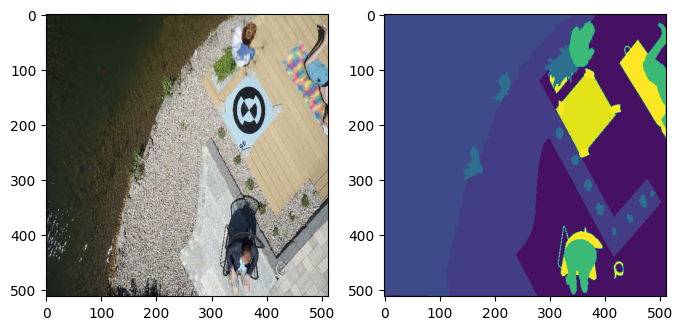

In [ ]:
fg, ax = plt.subplots(1,2, figsize=(8,16))
for image, mask in test_ds.take(1):
    ax[0].imshow(image[1,...])
    ax[1].imshow(tf.argmax(mask[1,...],axis=-1))

clear_output()

In [ ]:
%pip install keras-unet-collection -q -U
from keras_unet_collection import models, losses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
tf.keras.backend.clear_session()
model = models.swin_unet_2d((512, 512, 3), filter_num_begin=32,
                               n_labels=num_classes, depth=4, stack_num_down=2, stack_num_up=2,
                               patch_size=(4, 4), num_heads=[4, 8, 8, 8],
                               window_size=[4, 2, 2, 2], num_mlp=156,
                               output_activation='Softmax', shift_window=True,
                               name='swin_unet')
print(model.summary())

Model: "swin_unet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 patch_extract (patch_extra  (None, 16384, 48)            0         ['input_1[0][0]']             
 ct)                                                                                              
                                                                                                  
 patch_embedding (patch_emb  (None, 16384, 32)            525856    ['patch_extract[0][0]']       
 edding)                                                                                          
                                                                                    

In [ ]:
tf.config.experimental_run_functions_eagerly(True)
def focal_loss(predict, true):
    error = keras.losses.categorical_crossentropy(predict, true)
    pt = tf.exp(-error)
    focal_loss = (1 - pt) ** 2 * error
    return tf.reduce_mean(focal_loss)

def mean_iou(predict, true):
    predict = tf.argmax(predict, axis=-1)
    true = tf.argmax(true, axis=-1)
    return keras.metrics.MeanIoU(num_classes=num_classes)(predict, true)

model.compile(optimizer='adam',
             loss=focal_loss,
             metrics=['accuracy', mean_iou])

history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


Epoch 1/10
270/270 [==============================] - 793s 3s/step - loss: 1.3337 - accuracy: 0.5049 - mean_iou: 0.0491 - val_loss: 0.9948 - val_accuracy: 0.5871 - val_mean_iou: 0.0618
Epoch 2/10
270/270 [==============================] - 602s 2s/step - loss: 0.9138 - accuracy: 0.5892 - mean_iou: 0.0801 - val_loss: 0.8729 - val_accuracy: 0.6169 - val_mean_iou: 0.1006
Epoch 3/10
270/270 [==============================] - 601s 2s/step - loss: 0.7792 - accuracy: 0.6329 - mean_iou: 0.1123 - val_loss: 0.7715 - val_accuracy: 0.6520 - val_mean_iou: 0.1215
Epoch 4/10
270/270 [==============================] - 603s 2s/step - loss: 0.7042 - accuracy: 0.6583 - mean_iou: 0.1313 - val_loss: 0.8126 - val_accuracy: 0.6440 - val_mean_iou: 0.1300
Epoch 5/10
270/270 [==============================] - 643s 2s/step - loss: 0.6468 - accuracy: 0.6789 - mean_iou: 0.1478 - val_loss: 0.8066 - val_accuracy: 0.6293 - val_mean_iou: 0.1402
Epoch 6/10
270/270 [==============================] - 645s 2s/step - loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 485ms/step
(4, 512, 512)
(4, 512, 512)


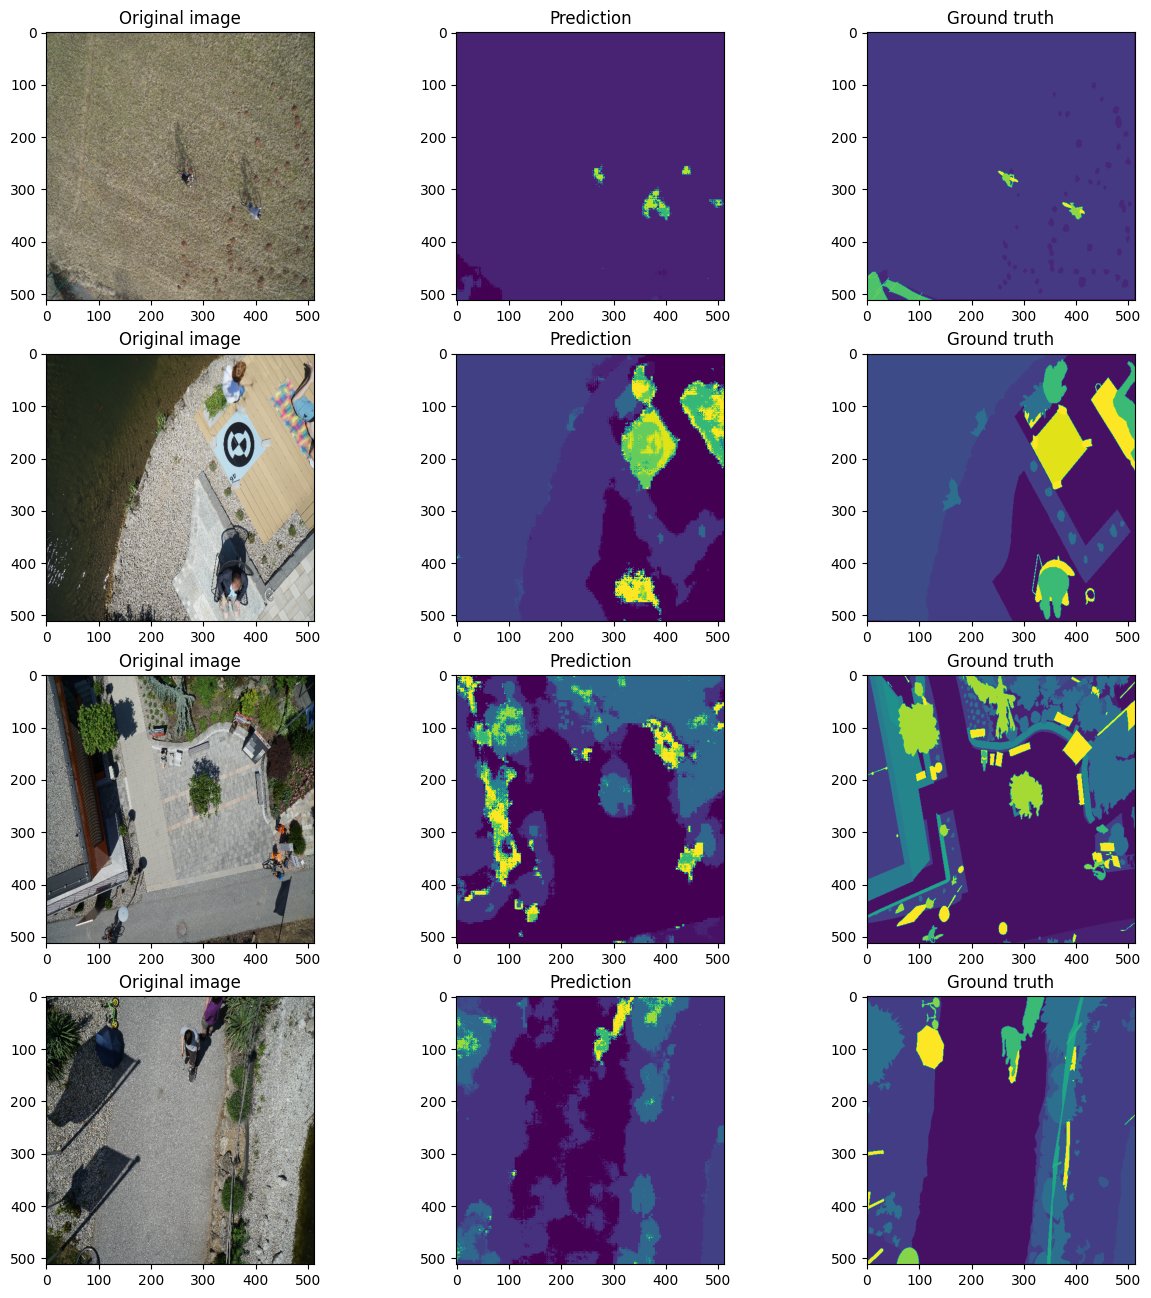

In [ ]:
model.save("version2.h5")

for images, masks in test_ds.take(1):
    pred = model.predict(images)

predictions = np.argmax(pred, axis=-1)
labels = np.argmax(masks, axis=-1)
print(labels.shape)
print(predictions.shape)

fig, ax = plt.subplots(BATCH_SIZE, 3, figsize=(15, 4 * BATCH_SIZE))
for j in range(BATCH_SIZE):
    ax[j, 0].imshow(images[j, ...].numpy())
    ax[j, 1].imshow(predictions[j, ...].astype('uint8'))
    ax[j, 2].imshow(labels[j, ...])
    ax[j, 0].set_title('Original image')
    ax[j, 1].set_title('Prediction')
    ax[j, 2].set_title('Ground truth')
plt.show()